In [13]:
import pandas as pd
import requests
from urllib.parse import urlencode

import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency 
import pingouin as pg
import scipy.stats as ss

sns.set(rc={'figure.figsize':(7,3)}, palette='colorblind', style="whitegrid")

Загрузим данные с Яндекс Диска.

In [2]:
#внешние ссылки
groups_df = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_df = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_df = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_df = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# напишем функцию для получения загрузочных ссылок с Яндекс Диска
def get_ds_from_yandex(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(df_final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
groups = pd.read_csv(get_ds_from_yandex(groups_df), sep = ';')
groups_add = pd.read_csv(get_ds_from_yandex(groups_add_df))
active_studs = pd.read_csv(get_ds_from_yandex(active_studs_df))
checks = pd.read_csv(get_ds_from_yandex(checks_df), sep = ';')

## 0. Разведочный анализ данных (EDA)

**groups** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа). 

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [9]:
groups.nunique()

id     74484
grp        2
dtype: int64

Посмотрим на соотношение групп.

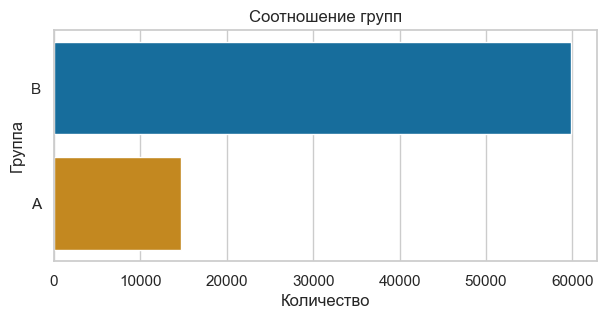

In [14]:
sns.countplot(y='grp', data=groups, palette='colorblind')
plt.title('Соотношение групп')
plt.xlabel('Количество')
plt.ylabel('Группа')
plt.show()

In [15]:
a_grp = len(groups[groups['grp'] == 'A'])
b_grp = len(groups) - a_grp
print(f'Контрольная группа: {a_grp} \nЦелевая группа: {b_grp}')

Контрольная группа: 14671 
Целевая группа: 59813


В файле groups нет пропущенных данных.
Данные принадлежат к подходящим типам.
Всего 74484 уникальных пользователя. Из них: 
- к целевой группе (B) принадлежат **59813** человека,
- к контрольной группе (A) принадлежат **14671** человека.

_____________

**groups_add** - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных.

In [16]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [17]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [18]:
groups_add.isnull().sum()

id     0
grp    0
dtype: int64

In [19]:
groups_add.nunique()

id     92
grp     2
dtype: int64

Посмотрим на соотношение групп.

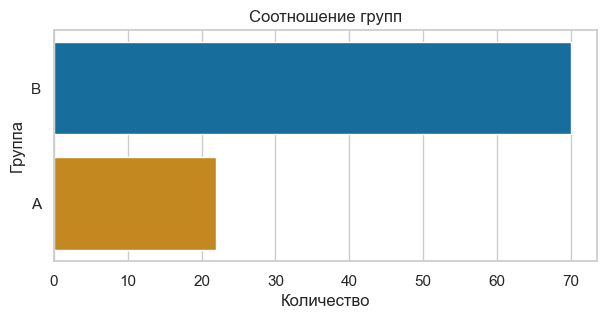

In [20]:
sns.countplot(y='grp', data=groups_add, palette='colorblind')
plt.title('Соотношение групп')
plt.xlabel('Количество')
plt.ylabel('Группа')
plt.show()

In [21]:
a_grp = len(groups_add[groups_add['grp'] == 'A'])
b_grp = len(groups_add) - a_grp
print(f'Контрольная группа: {a_grp} \nЦелевая группа: {b_grp}')

Контрольная группа: 22 
Целевая группа: 70


В файле groups_add нет пропущенных данных.
Данные принадлежат к подходящим типам.
Всего 92 уникальных пользователя. Из них: 
- к целевой группе (B) принадлежат **70** человека,
- к контрольной группе (A) принадлежат **22** человека.

Проверим, есть ли дублирование пользователей в файлах groups и groups_add.
Для этого соединим их.

In [22]:
full_group = pd.concat([groups, groups_add], join = 'outer', axis=0)
full_group.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [23]:
full_group.nunique()

id     74576
grp        2
dtype: int64

In [24]:
full_group[full_group.duplicated('id')]

,id,grp


Дублированных пользователей в данных нет.

------

**active_studs** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [25]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [26]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [27]:
active_studs.nunique()

student_id    8341
dtype: int64

In [28]:
active_studs.isnull().sum()

student_id    0
dtype: int64

In [29]:
#сменим student_id на id, чтобы название колонок в файлах было одинаковое.
active_studs = active_studs.rename(columns={'student_id': 'id'})

В файле active_studs нет пропущенных данных.
Данные принадлежат к подходящим типам.
Всего 8341 уникальных пользователя.

---

**checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [30]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [31]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [32]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [33]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

Посмотрим на распределение оплаты.

In [34]:
students_rev = (
    checks.groupby('rev', as_index=False)
    .agg({'student_id': 'count'})
    .rename(columns={'student_id':'count_students'})
    .sort_values('count_students', ascending=False)
)

In [35]:
students_rev['rev'].unique()

array([1900.    ,  290.    ,  690.    ,  199.    ,  990.    , 1900.0001,
        840.    , 1140.    ,  580.    ,  590.    ,  398.    , 1530.    ,
        870.    , 3660.    , 2910.    , 1980.    , 2890.    , 2099.    ,
       1160.    ,  489.    , 2220.    , 1180.    , 2820.    , 2190.    ,
       2900.    , 3260.    , 3040.    , 1339.    , 1968.    , 1830.    ,
       1729.    , 1388.    , 1050.    , 1039.    ,  880.    ,  796.    ,
        630.    ,  597.    , 4650.    ])

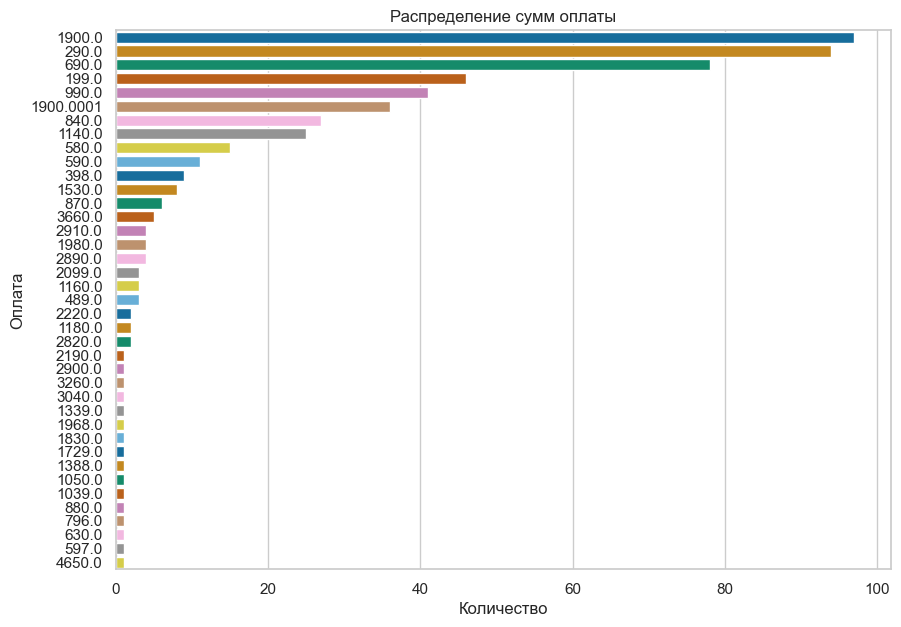

In [38]:
rev_str = students_rev.copy()
rev_str['rev'] = rev_str['rev'].astype('str')
plt.figure(figsize=(10, 7))
sns.barplot(y='rev', x='count_students', data=rev_str, palette='colorblind')
plt.title('Распределение сумм оплаты')
plt.xlabel('Количество')
plt.ylabel('Оплата')
plt.show()

В файле checks нет пропущенных данных. Данные принадлежат к подходящим типам. Всего 541 уникальных пользователя. 

Но также у 36 пользователей можно заметить сумму оплаты, которая имеет **аномальный ввид '1900.0001'**. Посмотрим на этих пользователей внимательнее.

In [39]:
#также поменяем student_id на id
checks = checks.rename(columns={'student_id': 'id'})
anomaly = checks.query('rev==1900.0001')
anomaly = anomaly.merge(full_group, how='inner')

In [40]:
anomaly.head()

,id,rev,grp
0,264473,1900.0001,B
1,338677,1900.0001,B
2,759073,1900.0001,B
3,766755,1900.0001,B
4,766874,1900.0001,B


In [41]:
anomaly['grp'].unique()

array(['B'], dtype=object)

Такая аномалия наблюдается только в группе B, т.е. в целевой группе.
Проверим, встречается ли данная аномалия только в основном файле, только в дополнительном или в обоих. 

In [42]:
main = anomaly.merge(groups, how='inner')
main.shape[0]

36

In [43]:
add = anomaly.merge(groups_add, how='inner')
add.shape[0]

0

Аномалия встречается только в основной выгрузке.

----

Для дальнейшего анализа необходимо соединить df, чтобы у нас имелась следующая информация:
- id,
- группа,
- активность во время эксперимента,
- оплата в дни проведения эксперимента.

In [44]:
active = list(active_studs['id'])

In [45]:
full_group['active'] = np.where(full_group['id'].isin(active), True, False)

In [46]:
full_df = full_group.merge(checks, how='left', on='id')

In [47]:
full_df.head()

,id,grp,active,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN


Проверим получившейся df на аномалии. К аномалиям можно отнести нарушение условий, т.е. оплата при неактивности во время эксперимента.

In [48]:
full_df_act_anom = full_df.query('active==False & rev>0')

In [49]:
full_df_act_anom.head()

,id,grp,active,rev
39,3185,B,False,690.0
121,25973,B,False,690.0
125,26280,B,False,690.0
223,100645,B,False,630.0
254,102534,B,False,580.0


In [50]:
full_df_act_anom.shape[0]

149

In [51]:
full_df_act_anom['grp'].value_counts()

grp
B    120
A     29
Name: count, dtype: int64

**149** пользователей при неактивности во время эксперимента совершили оплату. 
Аномалия наблюдается в обеих группах, поэтому можно сделать вывод, что причиной является не механика. 
Можно предположить что эти пользователи используют автоплатеж.

Для частоты дальнейшего анализа лучше исключить данных пользователей. Также, так как целью эксперимента является проверка новой системы оплаты, то следует учитывать только тех пользователей, кто вошел на сайт (активных). К тому же следует заполнить пропуски (пользователи, которые ничего не купили) нулями. Создадим отдельный столбец, который будет показывать, совершил ли пользователь покупку или нет.

In [52]:
full_df_new = full_df.query('active==True').fillna(0)

In [53]:
full_df_new['pay'] = np.where(full_df_new['rev'] > 0, True, False)

In [54]:
full_df_new.head()

,id,grp,active,rev,pay
1,1627,A,True,990.0,True
10,2085,B,True,0.0,False
12,2215,B,True,0.0,False
43,3391,A,True,0.0,False
45,3401,B,True,0.0,False


In [55]:
full_df_new.shape[0]

8341

Рассмотрим основные статистические характеристики по каждой группе.

In [56]:
full_df_new.groupby('grp')['rev'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


Кол-во пользователей, которые не совершили покупку, слишком велико, поэтому стоит рассмотреть данные без них.

In [57]:
full_df_new.query('pay==True').groupby('grp')['rev'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


В целевой группе (B), где предложена новая механика, все показатели выше, чем в контрольной группе (A), кроме минимальной оплаты, которая осталась прежней.

Также рассмотрим данные на распределение групп и распределение сумм по группам.

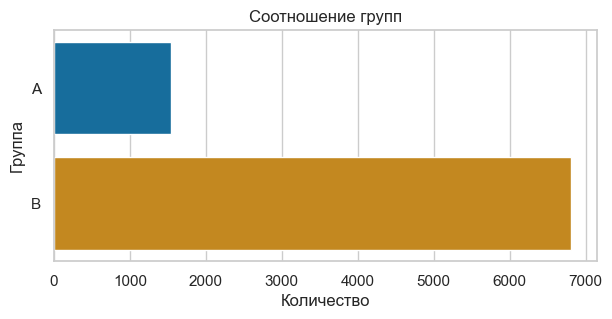

In [58]:
sns.countplot(y='grp', data=full_df_new, palette='colorblind')
plt.title('Соотношение групп')
plt.xlabel('Количество')
plt.ylabel('Группа')
plt.show()

In [59]:
a_grp = len(full_df_new[full_df_new['grp'] == 'A'])
b_grp = len(full_df_new) - a_grp
a_grp_per = round(a_grp / len(full_df_new) * 100)
b_grp_per = round(b_grp / len(full_df_new) * 100)
print(f'Контрольная группа: {a_grp} - {a_grp_per}% \nЦелевая группа: {b_grp} - {b_grp_per}%')

Контрольная группа: 1538 - 18% 
Целевая группа: 6803 - 82%


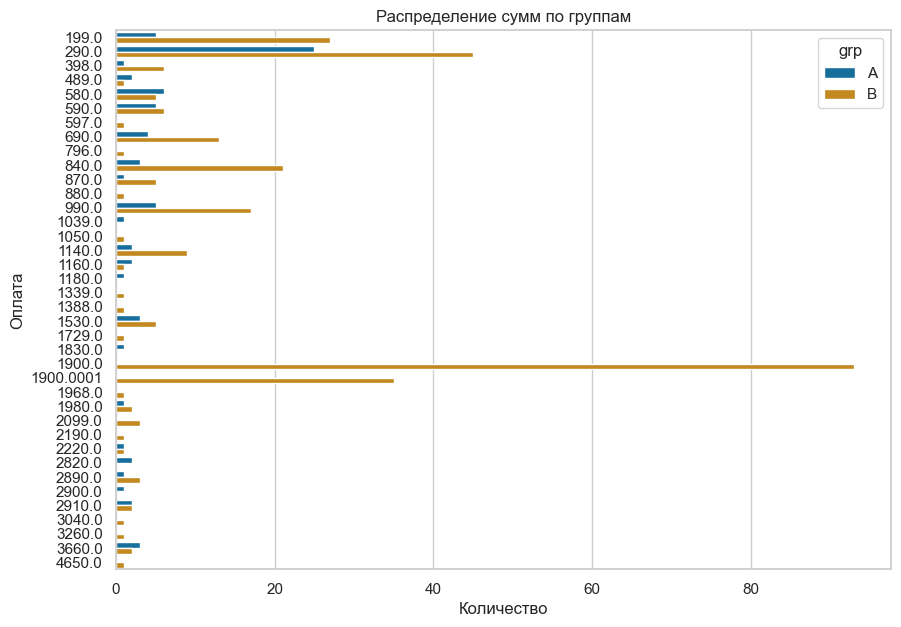

In [62]:
plt.figure(figsize=(10, 7))
sns.countplot(y='rev', data=full_df_new.query('pay==True'), hue='grp', palette='colorblind')
plt.title('Распределение сумм по группам')
plt.xlabel('Количество')
plt.ylabel('Оплата')
plt.show()

Из 8341:
- к целевой группе (B) принадлежат **6803** человека - **82%**,
- к контрольной группе (A) принадлежат **1538** человека - **18%**.

Из всех сумм можно выделить сумму в 290 для обоих групп. 
Также для целевой группы (B) выделяются: 
- сумма в **1900.0001**, которая, как было описано выше, является аномалией.
- сумма в **1900**, которая не только многократно превосходить все остальные суммы по распределению, но и полностью отсутствует в контрольной группе (A).

Проверим по аналогии с суммой в 1900.0001, где встречается сумма в 1900: только в основном файле, только в дополнительном или в обоих.

In [63]:
anomaly_2 = full_df_new.query('rev==1900')

In [64]:
main_2 = anomaly_2.merge(groups, how='inner')
main_2.shape[0]

92

In [65]:
add_2 = anomaly_2.merge(groups_add, how='inner')
add_2.shape[0]

1

Данная сумма встречается в 92 случаях в основной выгрузке и в 1 случае - в дополнительной.

## 1. Проверка метрик.

Так как информация ограничена суммой оплаты для каждого пользователя, то количество метрик, которые можно проверить, не очень велико. Следует проверить:
1. Конверсию в покупку: отношение числа тех, кто совершил покупку, и тех, кто посетил сайт, т.е. долю платящих клиентов.
2. Медианную сумму.
3. Средний доход, который был получен с активного пользователя (вошедшего на сайт).
4. Средний доход, который был получен с пользователя, совершившего покупку.

### **Метрика №1:**

### CR в покупку.

Н0: CR в покупку в группах **не различается**.

Н1: CR в покупку в группах **различается**.

In [66]:
CR = (full_df_new.groupby('grp',as_index=False)
      .agg({'pay':'mean'})
      .rename(columns={'pay':'CR'})
     )
CR['CR'] = round(CR.CR * 100, 2)
CR

,grp,CR
0,A,5.07
1,B,4.62


<Axes: xlabel='grp', ylabel='CR'>

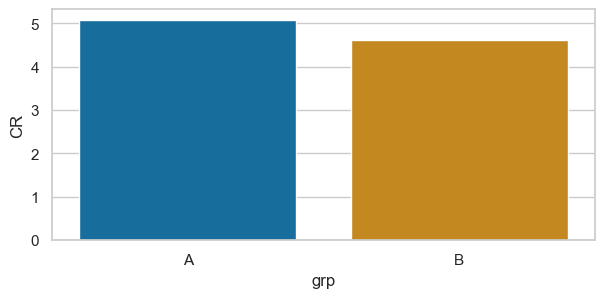

In [67]:
sns.barplot(data=CR, x='grp', y='CR', palette='colorblind')

Так как данные категориальные, используем Хи-квадрат.

In [68]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(full_df_new.grp, full_df_new.pay))
stat, p

(0.48480826522557896, 0.48625240457231045)

In [69]:
alpha = 0.05
if p <= alpha:
    print('Различия между двумя группами статистически значимы, поэтому мы отклоняем H0.')
else:
    print('Различия между двумя группами статистически не значимы, поэтому мы не отклоняем H0.')

Различия между двумя группами статистически не значимы, поэтому мы не отклоняем H0.


### **Метрика №2:**

### Медианная сумма. ###

Н0: медианная сумма в группах **не различается**.

Н1: медианная сумма в группах **различается**.

In [70]:
median = (full_df_new.query('pay==True')
          .groupby('grp', as_index=False)
          .agg({'rev':'median'})
          .rename(columns={'rev':'median'})
          .round(2)
         )
median

,grp,median
0,A,585.0
1,B,1140.0


<Axes: xlabel='grp', ylabel='median'>

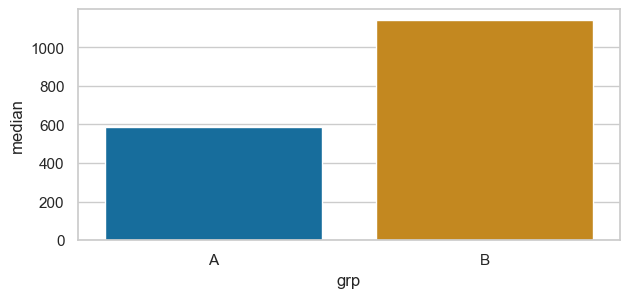

In [71]:
sns.barplot(data=median, x='grp', y='median', palette='colorblind')

Для сравнения медиан используем готовые функции bootstrap.

In [72]:
A_med = full_df_new.query('grp=="A" & pay==True').rev
A_array = pg.compute_bootci(A_med, func=np.median, n_boot=20000, confidence=0.95)
A_array

array([344., 690.])

In [73]:
B_med = full_df_new.query('grp=="B" & pay==True').rev
B_array = pg.compute_bootci(B_med, func=np.median, n_boot=20000, confidence=0.95)
B_array

array([ 855. , 1363.5])

In [74]:
B_array - A_array 

array([511. , 673.5])

Доверительные интервалы не перекрываются, что значит, что различия между двумя группами статистически значимы, поэтому мы отклоняем H0.

### **Метрика №3:**

### ARPAU (средний  доход с активного пользователя).

Н0: ARPAU в группах **не различается**.

Н1: ARPAU в группах **различается**.

В данном случае используем Т-тест Стьюдента. Для этого нам надо проверить данные на нормальность и на различия в дисперсиях.

Для начала расчитаем ARPAU для каждой группы.

In [75]:
ARPAU = (full_df_new.groupby('grp', as_index=False)
        .agg({'rev':'mean'})
        .rename(columns={'rev':'ARPAU'})
        .round(2)
       )
ARPAU

,grp,ARPAU
0,A,47.35
1,B,58.06


In [76]:
ARPAU_A = full_df_new.query('grp=="A"').rev
ARPAU_B = full_df_new.query('grp=="B"').rev

Проверим данные на различия в десперсиях.

In [77]:
pg.homoscedasticity(data=full_df_new, dv='rev', group='grp')

,W,pval,equal_var
levene,1.501461,0.220481,True


Дисперсии по группам равны.

Проверим данные на нормальность.

<Axes: xlabel='rev', ylabel='Count'>

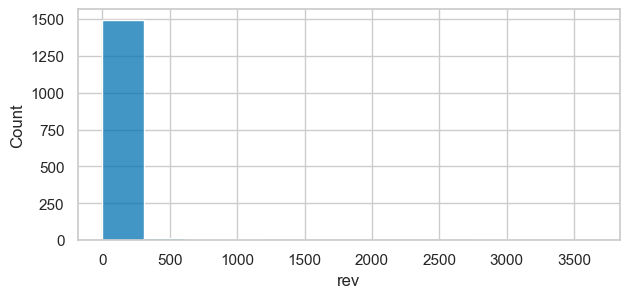

In [78]:
sns.histplot(ARPAU_A)

<Axes: xlabel='rev', ylabel='Count'>

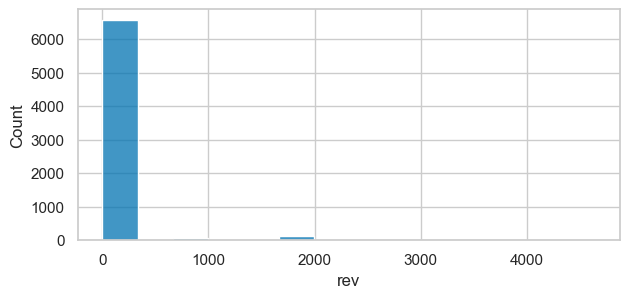

In [79]:
sns.histplot(ARPAU_B)

Исключим суммы, равные 0, т.к. они выбиваются. 

In [80]:
print(ss.normaltest(full_df_new.query('grp=="A" & pay==True').rev))
print(ss.normaltest(full_df_new.query('grp=="B" & pay==True').rev))

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


Данные распределены ненормально после исключения выброса в виде суммы, равной 0.

Дисперсии гомогенны, распределение ненормально, поэтому необходимо использовать Манна-Уитни. Но мы сравниваем средние. Из-за достаточного размера выборки можно использовать Т-тест Стьюдента.

In [81]:
stat, p = ss.ttest_ind(ARPAU_A, ARPAU_B)
p

0.22048133326988378

In [82]:
alpha = 0.05
if p <= alpha:
    print('Различия между двумя группами статистически значимы, поэтому мы отклоняем H0.')
else:
    print('Различия между двумя группами статистически не значимы, поэтому мы не отклоняем H0.')

Различия между двумя группами статистически не значимы, поэтому мы не отклоняем H0.


### **Метрика №4:**

### ARPPU (средний доход на платящего пользователя).

Н0: ARPPU в группах **не различается**.

Н1: ARPPU в группах **различается**.

Рассчитаем ARPPU для каждой группы.

Так как речь идет о пользователях, которые заплатили, то необходимо исключить тех, кто не совершил покупку.

In [83]:
ARPPU = (full_df_new.query('pay==True')
         .groupby('grp', as_index=False)
         .agg({'rev':'mean'})
         .rename(columns={'rev':'ARPPU'})
         .round(2)
        )
ARPPU

,grp,ARPPU
0,A,933.59
1,B,1257.88


В этот раз используем bootstrap.

In [105]:
ARPPU_boot = []
for i in range(5000):
    sample_ARPPU = full_df_new.sample(frac=1, replace=True).query('pay==True').groupby('grp').rev.mean()
    ARPPU_boot.append(sample_ARPPU)
    
ARPPU_boot = pd.DataFrame(ARPPU_boot)
ARPPU_boot.head()

grp,A,B
rev,997.786667,1243.491921
rev,798.440476,1221.973605
rev,966.304878,1191.943072
rev,1025.487500,1226.983060
rev,882.950495,1281.767593


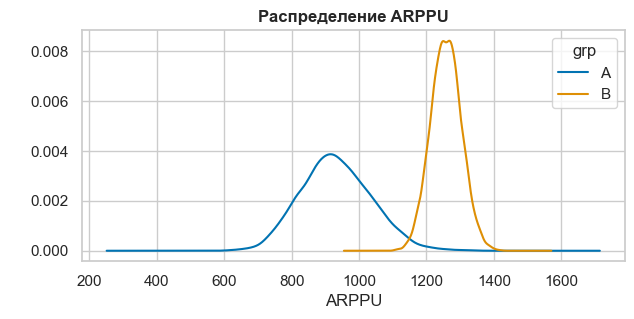

In [107]:
ARPPU_boot.plot.kde()
plt.xlabel("ARPPU")
plt.ylabel(" ")
plt.title("Распределение ARPPU", fontweight="bold")

plt.show()

In [108]:
ARPPU_boot['diff'] = ARPPU_boot.B-ARPPU_boot.A
print(ARPPU_boot['diff'].quantile(0.975))
print(ARPPU_boot['diff'].quantile(0.025))

538.1654886045128
97.26879163892913


Доверительные интервалы не перекрываются, что значит, что различия между двумя группами статистически значимы, поэтому мы отклоняем H0.